In [1]:
import os
from scipy import stats

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from scipy.stats import skew

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from scipy.spatial.distance import cdist
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import inv

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

import seaborn as sns

In [2]:
notebook_directory = os.getcwd()
save_path = notebook_directory

In [3]:
# Loading the spotify popularity dataset
sp = pd.read_csv("dataset.csv")

In [4]:
sp = sp.drop('Unnamed: 0', axis=1)
sp.head(2)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.461,1,-6.746,0,0.1430,0.0322,0.000001,0.358,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.166,1,-17.235,1,0.0763,0.9240,0.000006,0.101,0.267,77.489,4,acoustic


# Exploratory data analysis

In [5]:
numeric_columns = ['popularity', 'duration_ms', 'danceability', 'energy','key', 'loudness', 'mode', 'speechiness',
                   'acousticness','instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']


for var in numeric_columns:
    mmax = sp[var].max()
    mmin = sp[var].min()
    print(f'The {var} variable ranges between {mmin} and {mmax}')

The popularity variable ranges between 0 and 100
The duration_ms variable ranges between 0 and 5237295
The danceability variable ranges between 0.0 and 0.985
The energy variable ranges between 0.0 and 1.0
The key variable ranges between 0 and 11
The loudness variable ranges between -49.531 and 4.532
The mode variable ranges between 0 and 1
The speechiness variable ranges between 0.0 and 0.965
The acousticness variable ranges between 0.0 and 0.996
The instrumentalness variable ranges between 0.0 and 1.0
The liveness variable ranges between 0.0 and 1.0
The valence variable ranges between 0.0 and 0.995
The tempo variable ranges between 0.0 and 243.372
The time_signature variable ranges between 0 and 5


## Graphs  - Bivariate Analysis

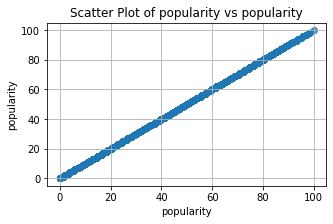

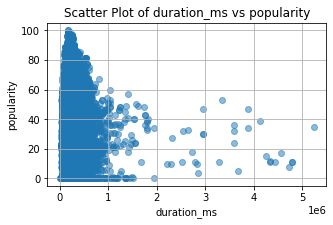

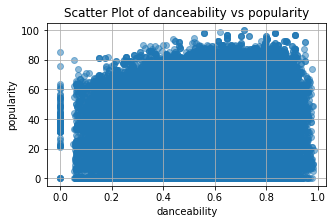

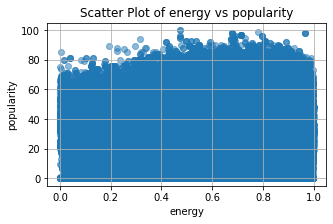

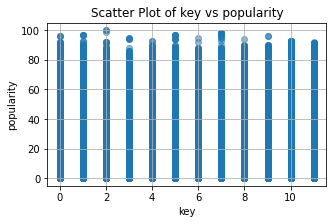

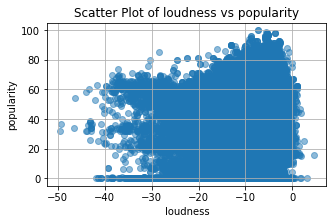

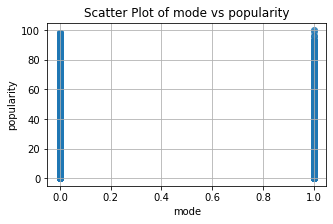

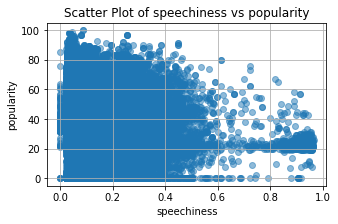

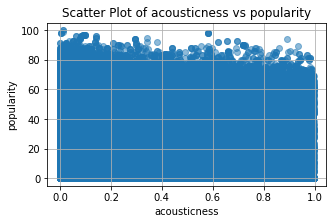

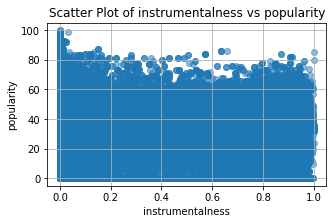

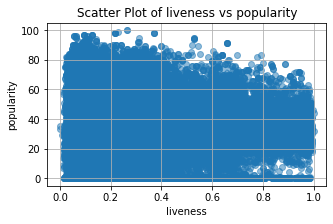

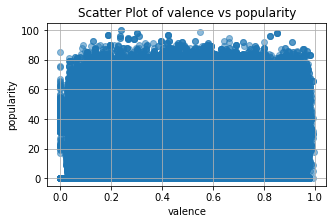

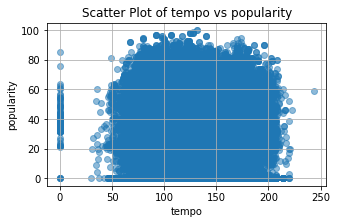

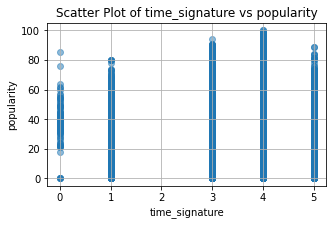

In [6]:
# Target feature
target_feature = 'popularity'

for var in numeric_columns:
    plt.figure(figsize=(5, 3))
    plt.scatter(sp[var], sp[target_feature], alpha=0.5)
    plt.xlabel(var)
    plt.ylabel(target_feature)
    plt.title(f'Scatter Plot of {var} vs {target_feature}')
    plt.grid(True)
    plt.show()

## Analyzing the correlations between variables

<AxesSubplot:>

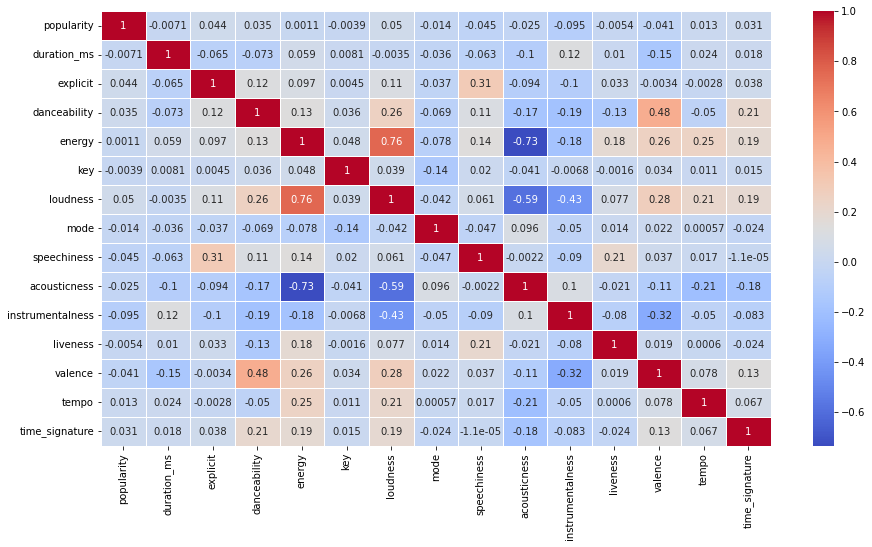

In [7]:
correlation_matrix = sp.corr()
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)

## Features density

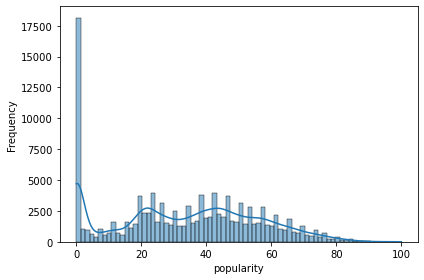

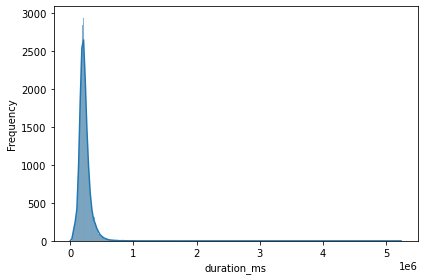

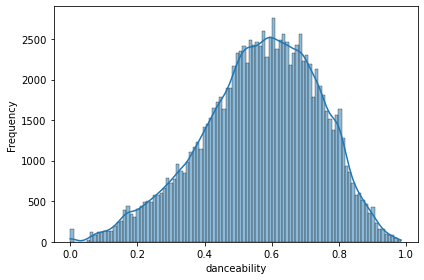

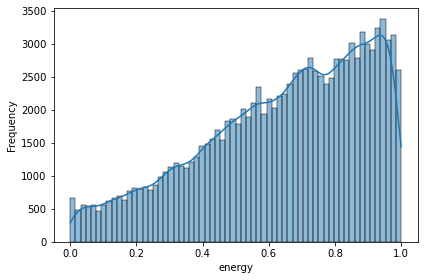

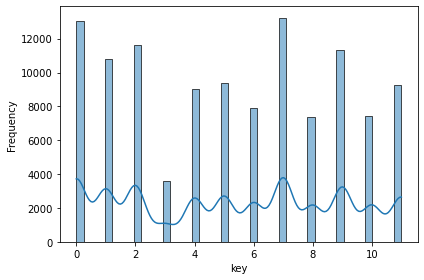

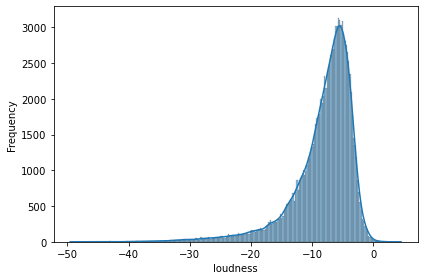

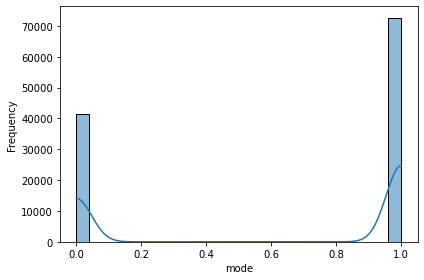

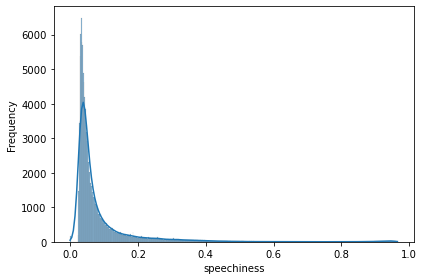

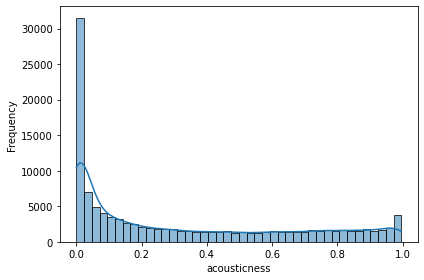

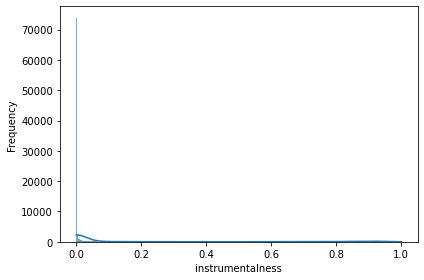

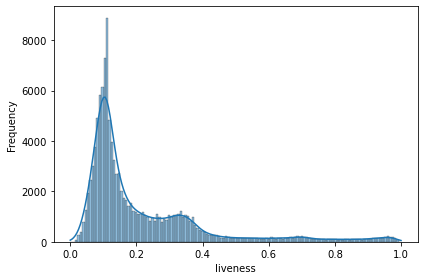

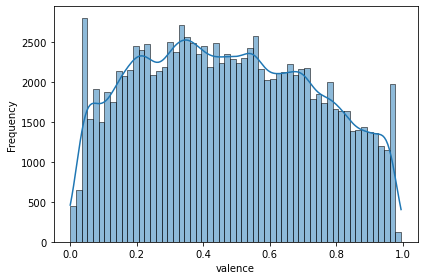

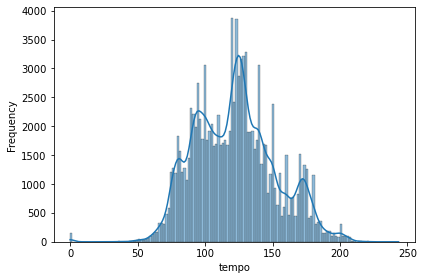

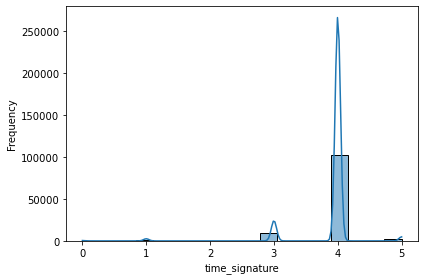

In [8]:
for i, var in enumerate(numeric_columns, 1):
    plt.figure(figsize=(6, 4))  # Create a new figure for each plot
    sns.histplot(sp[var], kde=True)
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.tight_layout()

    # Show the plot without saving it
    plt.show(block=False)

# Data Preprocessing

## Data Normalization (z-score)

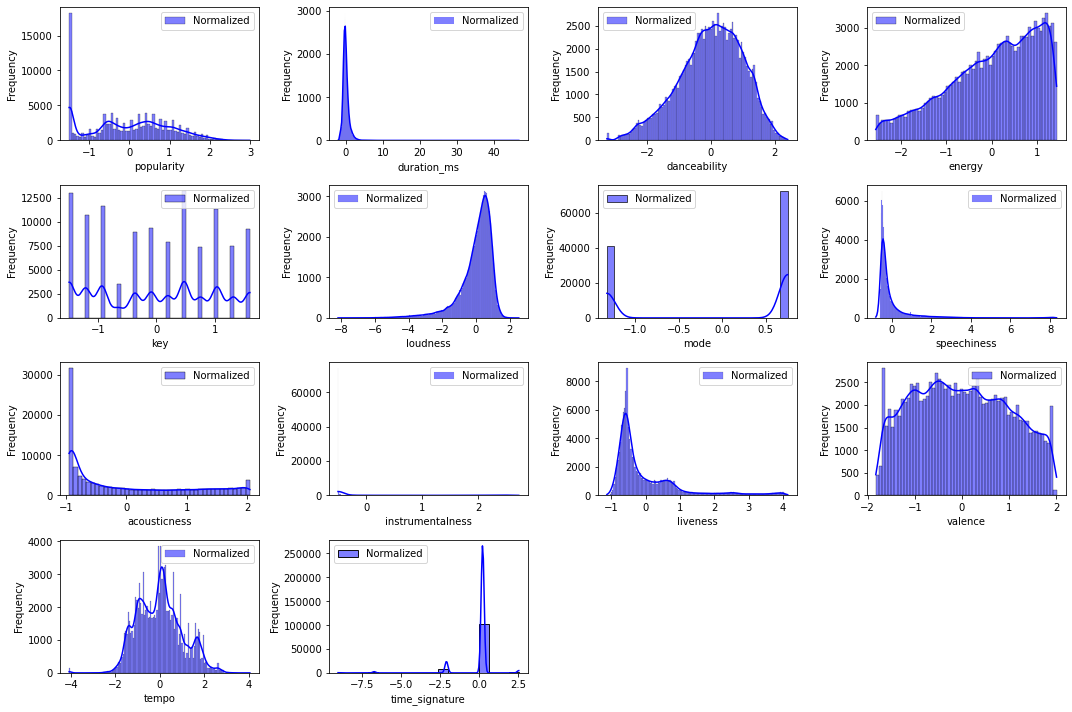

In [9]:
z_scaler = StandardScaler()

df_norm = pd.DataFrame(z_scaler.fit_transform(sp[numeric_columns]), columns=numeric_columns)

plt.figure(figsize=(15, 10))
for i, var in enumerate(numeric_columns, 1):
    plt.subplot(4, 4, i)
    sns.histplot(df_norm[var], kde=True, color = 'blue', label='Normalized')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

## Min Max Scaling

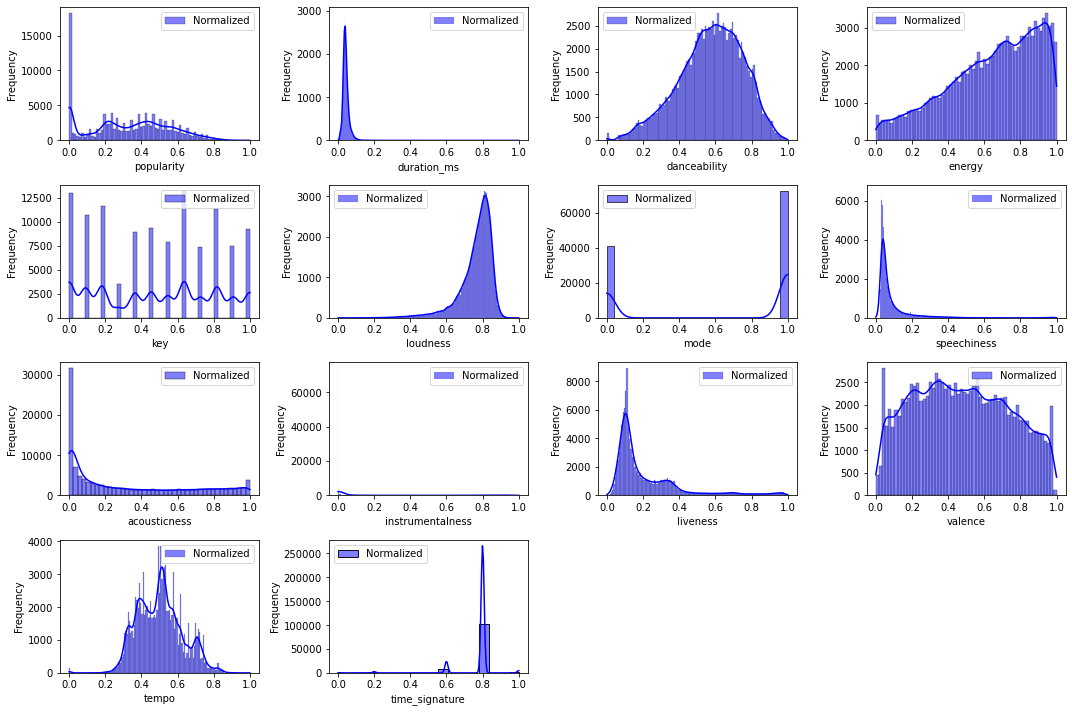

In [10]:
minmax_scaler = MinMaxScaler()

scaled_df = pd.DataFrame(minmax_scaler.fit_transform(sp[numeric_columns]), columns=numeric_columns)


plt.figure(figsize=(15, 10))
for i, var in enumerate(numeric_columns, 1):
    plt.subplot(4, 4, i)
    sns.histplot(scaled_df[var], kde=True, color = 'blue', label='Normalized')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

# Ridge Regression

In [11]:
import numpy as np
from sklearn.base import BaseEstimator

class RidgeRegression(BaseEstimator):
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.coef_ = None  
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # Adding regularization term to the loss function
        XtX = X.T @ X
        reg_term = self.alpha * np.eye(n_features)
        coef = np.linalg.solve(XtX + reg_term, X.T @ y)
        self.coef_ = coef.reshape(-1, 1)
        
        return self
    
    def predict(self, X):
        if self.coef_ is None:
            raise ValueError("Model has not been fitted yet.")
            
        if X.shape[1] != self.coef_.shape[0]:
            raise ValueError("Number of features in X does not match the number of coefficients.")
            
        # Ensuring that X is a NumPy array
        X = np.array(X)
        
        y_pred = X @ self.coef_
        return y_pred

# Cross Validation

In [12]:
def train_validation_test_split(df, X_columns, y_column, test_size=0.2, validation_size=0.2, random_state=42):
    # Splitting data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(df[X_columns], df[y_column], test_size=test_size, random_state=random_state)
    
    # Further split training set into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_size, random_state=random_state)
    
    return X_train, X_val, X_test, y_train, y_val, y_test


def cross_validation_metrics(df_name, X_train, y_train, X_columns, y_column, alpha_values, n_splits=5, random_state=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    results = pd.DataFrame(columns=['DataFrame', 'Alpha', 'R²', 'MAE', 'MSE'])
    
    for alpha in alpha_values:
        r2_scores_alpha = []
        mae_scores_alpha = []
        mse_scores_alpha = []
        
        for train_index, val_index in kf.split(X_train):
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
            
            # Fitting Ridge Regression model
            ridge_reg = RidgeRegression(alpha=alpha)
            ridge_reg.fit(X_train_fold, y_train_fold)
            
            # Predicting on the validation set
            y_pred = ridge_reg.predict(X_val_fold)
            
            r2 = r2_score(y_val_fold, y_pred)
            mae = mean_absolute_error(y_val_fold, y_pred)
            mse = mean_squared_error(y_val_fold, y_pred)
            
            # Append scores for this fold
            r2_scores_alpha.append(r2)
            mae_scores_alpha.append(mae)
            mse_scores_alpha.append(mse)
        
        # Average scores across folds for this alpha
        r2_avg_alpha = np.mean(r2_scores_alpha)
        mae_avg_alpha = np.mean(mae_scores_alpha)
        mse_avg_alpha = np.mean(mse_scores_alpha)
        
        results = results.append({'DataFrame': df_name,
                                  'Alpha': alpha,
                                  'R²': r2_avg_alpha,
                                  'MAE': mae_avg_alpha,
                                  'MSE': mse_avg_alpha}, ignore_index=True)
    
    best_alpha = results.loc[results['R²'].astype(float).idxmax()]['Alpha']
    return {'results_df': results, 'best_alpha': best_alpha}

# Model Application - Numerical Variables

In [13]:
X_columns =  ['duration_ms', 'danceability', 'energy','key', 'loudness', 'speechiness',
                   'acousticness','instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']
y_column = 'popularity'

alpha_values = [0.0001, 0.001, 0.01, 0.1, 1, 10,100]  

In [14]:
dataframes = {
    'Original': sp,
    'Normalized data': df_norm,
    'Scaled data': scaled_df
}

**Splitting the data**

In [15]:
split_datasets = {}  

for name, df in dataframes.items():
    X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(df, X_columns, y_column)
    
    split_datasets[name] = {
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test
    }

## 1. Cross Validation 

In [16]:
results_dict = {}

for name, splits in split_datasets.items():
    X_train = splits['X_train']
    y_train = splits['y_train']
    
    ridge = RidgeRegression()
    param_grid = {'alpha': alpha_values}
    
    # Performing cross-validation
    grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='r2')
    grid_search.fit(X_train, y_train)
    
    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_results['DataFrame'] = name
    cv_results['Mean Test R²'] = cv_results['mean_test_score']
    cv_results = cv_results[['DataFrame', 'param_alpha', 'Mean Test R²']]
    
    results_dict[name] = {
        'best_alpha': grid_search.best_params_['alpha'],
        'cv_results': cv_results
    }

cv_results_df = pd.concat([results['cv_results'] for results in results_dict.values()], ignore_index=True)
cv_results_df

,DataFrame,param_alpha,Mean Test R²
0,Original,0.0001,0.010691
1,Original,0.001,0.010691
2,Original,0.01,0.010691
3,Original,0.1,0.010691
4,Original,1,0.010691
5,Original,10,0.010689
6,Original,100,0.010455
7,Normalized data,0.0001,0.022725
8,Normalized data,0.001,0.022725
9,Normalized data,0.01,0.022725


In [17]:
best_alpha_results = []

for name, results in results_dict.items():
    best_alpha = results['best_alpha']
    best_r2 = results['cv_results'][results['cv_results']['param_alpha'] == best_alpha]['Mean Test R²'].values[0]
    
    best_alpha_results.append({
        'DataFrame': name,
        'Best Alpha': best_alpha,
        'Mean Test R²': best_r2
    })

best_alpha_df = pd.DataFrame(best_alpha_results)
best_alpha_df

,DataFrame,Best Alpha,Mean Test R²
0,Original,1,0.010691
1,Normalized data,100,0.022725
2,Scaled data,10,0.016963


**Plotting the results**

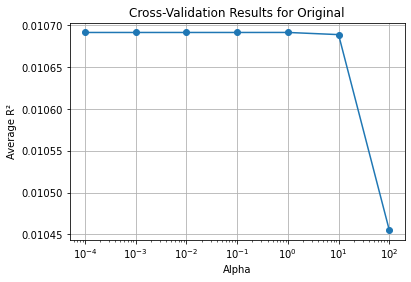

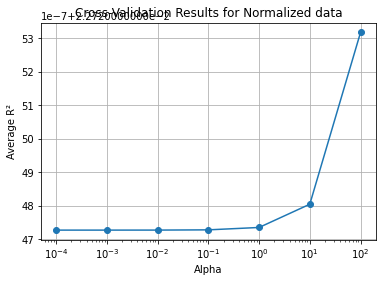

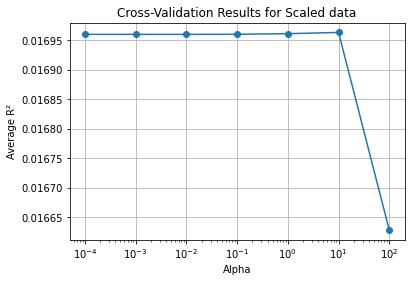

In [18]:
for name, results in results_dict.items():
    plt.figure()
    plt.plot(results['cv_results']['param_alpha'], results['cv_results']['Mean Test R²'], marker='o')
    plt.title(f'Cross-Validation Results for {name}')
    plt.xlabel('Alpha')
    plt.ylabel('Average R²')
    plt.xscale('log')
    plt.grid(True)
    plt.show()

## 2. Final model Training and Evaluation 

In [19]:
final_results = []

for name, splits in split_datasets.items():
    best_alpha = results_dict[name]['best_alpha']
    
    # Combining training and validation sets
    X_train_combined = pd.concat([splits['X_train'], splits['X_val']])
    y_train_combined = pd.concat([splits['y_train'], splits['y_val']])
    
    # Training the final model on the combined training set
    final_model = RidgeRegression(alpha=best_alpha)
    final_model.fit(X_train_combined, y_train_combined)
    
    # Evaluating on the test set
    y_test_pred = final_model.predict(splits['X_test'])
    test_r2 = r2_score(splits['y_test'], y_test_pred)
    
    final_results.append({
        'DataFrame': name,
        'Best Alpha': best_alpha,
        'Test R²': test_r2
    })

final_results_df = pd.DataFrame(final_results)
final_results_df

,DataFrame,Best Alpha,Test R²
0,Original,1,0.009514
1,Normalized data,100,0.020683
2,Scaled data,10,0.015324


## 3. Direct Fitting Without Cross-Validation

In [20]:
direct_fit_results = []

for name, splits in split_datasets.items():
    X_train = splits['X_train']
    y_train = splits['y_train']
    X_test = splits['X_test']
    y_test = splits['y_test']
    
    for alpha in alpha_values:
        model = RidgeRegression(alpha=alpha)
        model.fit(X_train, y_train)
        
        # Evaluate on the test set
        y_test_pred = model.predict(X_test)
        test_r2 = r2_score(y_test, y_test_pred)
        
        direct_fit_results.append({
            'DataFrame': name,
            'Alpha': alpha,
            'Test R²': test_r2
        })

direct_fit_results_df = pd.DataFrame(direct_fit_results)
direct_fit_results_df

,DataFrame,Alpha,Test R²
0,Original,0.0001,0.009655
1,Original,0.0010,0.009655
2,Original,0.0100,0.009655
3,Original,0.1000,0.009655
4,Original,1.0000,0.009654
5,Original,10.0000,0.009645
6,Original,100.0000,0.009427
7,Normalized data,0.0001,0.020854
8,Normalized data,0.0010,0.020854
9,Normalized data,0.0100,0.020854


In [21]:
best_results_index = direct_fit_results_df.groupby('DataFrame')['Test R²'].idxmax()
best_results_df = direct_fit_results_df.loc[best_results_index]
best_results_df.reset_index(drop=True, inplace=True)

best_results_df

,DataFrame,Alpha,Test R²
0,Normalized data,100.0000,0.020858
1,Original,0.0001,0.009655
2,Scaled data,10.0000,0.015460


**Plotting the results**

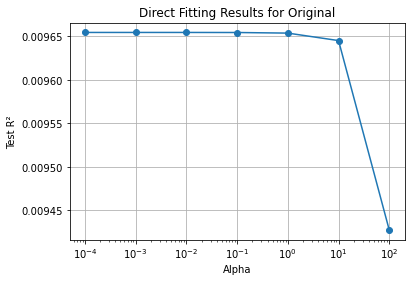

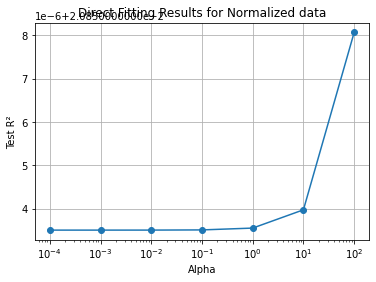

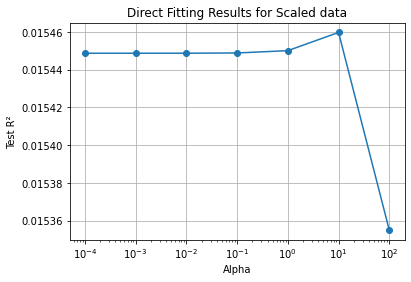

In [22]:
for name in dataframes.keys():
    df_results = direct_fit_results_df[direct_fit_results_df['DataFrame'] == name]
    plt.figure()
    plt.plot(df_results['Alpha'], df_results['Test R²'], marker='o')
    plt.title(f'Direct Fitting Results for {name}')
    plt.xlabel('Alpha')
    plt.ylabel('Test R²')
    plt.xscale('log')
    plt.grid(True)
    plt.show()

# Including categorical variables

In [23]:
cat_df = sp.copy()

In [24]:
sp['track_genre'].nunique()

114

In [25]:
# Encoding 'explicit' feature
label_encoder = LabelEncoder()
cat_df['explicit_encoded'] = label_encoder.fit_transform(cat_df['explicit'])

In [26]:
cat_df['explicit_encoded'].unique()

array([0, 1], dtype=int64)

In [27]:
import category_encoders as ce

# Instantiating the encoder with specified columns and smoothing parameter
encoder = ce.TargetEncoder(cols=['track_genre'], smoothing=10)

# Fitting and transforming the encoder on the training data
cat_df = encoder.fit_transform(cat_df, cat_df['popularity'])

cat_df['track_genre'].unique()

array([42.483, 24.399, 33.943, 24.337, 44.191, 48.772, 22.449, 25.676,
       31.188, 44.67 , 20.123, 43.802, 34.739, 12.339, 35.047, 53.651,
       13.055, 33.338, 24.628, 17.028, 22.69 , 33.467, 32.169, 44.808,
       11.174, 33.522, 27.536, 26.657, 40.039, 42.317, 35.032, 36.075,
       44.325, 48.128, 38.006, 41.826, 41.067, 32.322, 40.933, 26.751,
       41.639, 28.913, 14.625, 37.825, 49.594, 29.526, 21.716, 42.775,
       36.105, 26.623, 26.226, 37.759, 16.355, 34.156, 15.766, 49.539,
       40.657, 38.895, 31.041,  2.21 , 26.656, 24.707, 41.143, 40.664,
       13.628, 56.896, 14.888,  8.297, 25.656, 30.358, 45.025, 43.705,
       43.477, 34.022, 40.792, 29.065, 24.621, 44.298, 20.982, 45.273,
       59.283, 47.576, 26.898, 46.615, 42.778, 38.236, 38.291, 36.687,
       20.63 , 23.858, 34.434, 19.001, 31.5  ,  3.245, 52.379, 28.066,
       38.826, 47.866, 31.246, 37.813, 35.126, 35.071, 19.795, 37.922,
       26.108, 37.175, 36.576, 19.871, 39.042, 37.635, 34.46 , 40.698,
      

## Correlation Heatmap

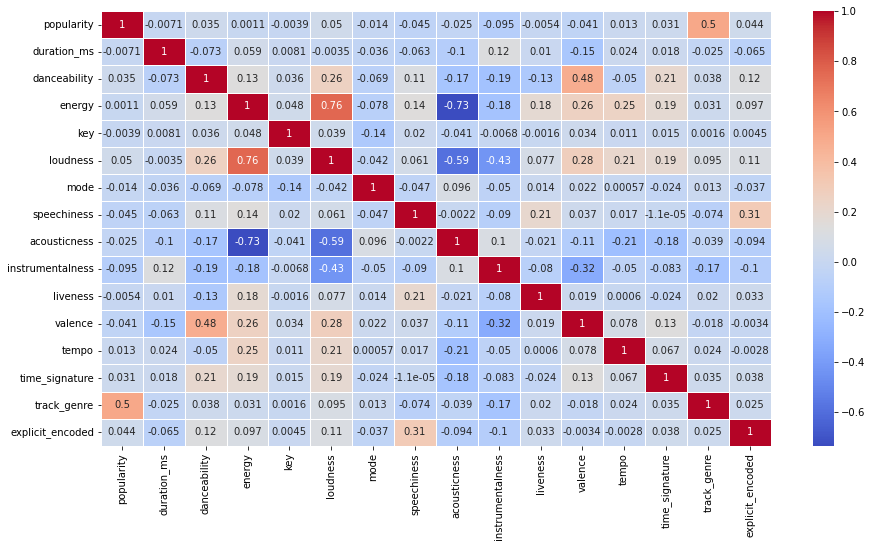

In [28]:
columns_to_include = [col for col in cat_df.columns if col != 'explicit']
correlation_matrix = cat_df[columns_to_include].corr()

save_path = os.path.join(notebook_directory, "correlation_heatmap_CV.png")

plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.savefig(save_path)

plt.show()

# Data Preprocessing

## z_score Normalization

In [29]:
variables = ['popularity','duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode',
                    'speechiness', 'acousticness', 'instrumentalness', 
                    'liveness', 'valence', 'tempo', 'time_signature', 'explicit_encoded', 'track_genre']

In [30]:
cat_df_norm = pd.DataFrame(z_scaler.fit_transform(cat_df[variables]), columns=variables)

## MinMax Scaling

In [31]:
cat_scaled_df = pd.DataFrame(minmax_scaler.fit_transform(cat_df[variables]), columns=variables)

In [32]:
X_columns_cat = ['duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode',
                   'speechiness', 'acousticness', 'instrumentalness', 
                   'liveness', 'valence', 'tempo', 'time_signature', 'explicit_encoded', 'track_genre']
y_column_cat = 'popularity'

# Model Application - Including categorical variables

In [33]:
dataframes = {
    'Original': cat_df,
    'Normalized data': cat_df_norm,
    'Scaled data': cat_scaled_df
}

**Splitting data**

In [34]:
split_datasets = {}  

for name, df in dataframes.items():
    X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(df,  X_columns_cat, y_column_cat)
    
    split_datasets[name] = {
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test
    }

## 1. Cross Validation

In [35]:
results_dict = {}

for name, splits in split_datasets.items():
    X_train = splits['X_train']
    y_train = splits['y_train']
    
    ridge = RidgeRegression()
    param_grid = {'alpha': alpha_values}
    
    # Performing cross-validation
    grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='r2')
    grid_search.fit(X_train, y_train)
    
    # Storing the results
    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_results['DataFrame'] = name
    cv_results['Mean Test R²'] = cv_results['mean_test_score']
    cv_results = cv_results[['DataFrame', 'param_alpha', 'Mean Test R²']]
    
    results_dict[name] = {
        'best_alpha': grid_search.best_params_['alpha'],
        'cv_results': cv_results
    }

# Concatenating cross-validation results into a single DF
cv_results_df = pd.concat([results['cv_results'] for results in results_dict.values()], ignore_index=True)
cv_results_df

,DataFrame,param_alpha,Mean Test R²
0,Original,0.0001,0.256784
1,Original,0.001,0.256784
2,Original,0.01,0.256784
3,Original,0.1,0.256784
4,Original,1,0.256784
5,Original,10,0.256784
6,Original,100,0.256776
7,Normalized data,0.0001,0.256817
8,Normalized data,0.001,0.256817
9,Normalized data,0.01,0.256817


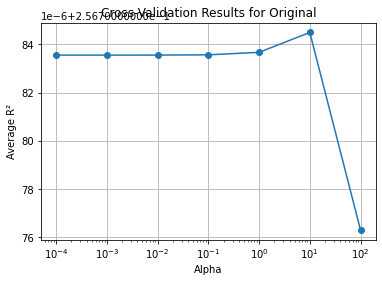

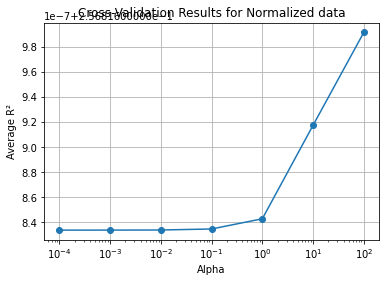

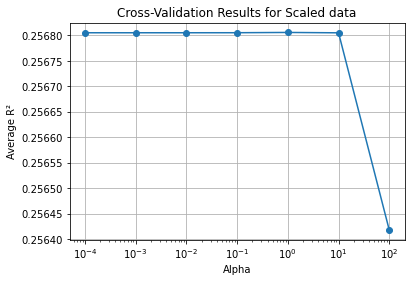

In [36]:
for name, results in results_dict.items():
    plt.figure()
    plt.plot(results['cv_results']['param_alpha'], results['cv_results']['Mean Test R²'], marker='o')
    plt.title(f'Cross-Validation Results for {name}')
    plt.xlabel('Alpha')
    plt.ylabel('Average R²')
    plt.xscale('log')
    plt.grid(True)
    plt.show()

In [37]:
best_alpha_results = []

for name, results in results_dict.items():
    best_alpha = results['best_alpha']
    best_r2 = results['cv_results'][results['cv_results']['param_alpha'] == best_alpha]['Mean Test R²'].values[0]
    
    best_alpha_results.append({
        'DataFrame': name,
        'Best Alpha': best_alpha,
        'Mean Test R²': best_r2
    })

best_alpha_df = pd.DataFrame(best_alpha_results)
best_alpha_df

,DataFrame,Best Alpha,Mean Test R²
0,Original,10,0.256784
1,Normalized data,100,0.256817
2,Scaled data,1,0.256806


## 2. Final model Training and Evaluation

In [38]:
final_results = []

for name, splits in split_datasets.items():
    best_alpha = results_dict[name]['best_alpha']
    
    X_train_combined = pd.concat([splits['X_train'], splits['X_val']])
    y_train_combined = pd.concat([splits['y_train'], splits['y_val']])
    
    final_model = RidgeRegression(alpha=best_alpha)
    final_model.fit(X_train_combined, y_train_combined)
    
    y_test_pred = final_model.predict(splits['X_test'])
    test_r2 = r2_score(splits['y_test'], y_test_pred)
    
    final_results.append({
        'DataFrame': name,
        'Best Alpha': best_alpha,
        'Test R²': test_r2
    })

final_results_df = pd.DataFrame(final_results)
final_results_df

,DataFrame,Best Alpha,Test R²
0,Original,10,0.259830
1,Normalized data,100,0.259773
2,Scaled data,1,0.259771


## 3. Direct Fitting Without Cross-Validation

In [39]:
direct_fit_results = []

for name, splits in split_datasets.items():
    X_train = splits['X_train']
    y_train = splits['y_train']
    X_test = splits['X_test']
    y_test = splits['y_test']
    
    for alpha in alpha_values:
        model = RidgeRegression(alpha=alpha)
        model.fit(X_train, y_train)
        
        # Evaluating on the test set
        y_test_pred = model.predict(X_test)
        test_r2 = r2_score(y_test, y_test_pred)
        
        direct_fit_results.append({
            'DataFrame': name,
            'Alpha': alpha,
            'Test R²': test_r2
        })

direct_fit_results_df = pd.DataFrame(direct_fit_results)
direct_fit_results_df

,DataFrame,Alpha,Test R²
0,Original,0.0001,0.259910
1,Original,0.0010,0.259910
2,Original,0.0100,0.259910
3,Original,0.1000,0.259910
4,Original,1.0000,0.259910
5,Original,10.0000,0.259914
6,Original,100.0000,0.259945
7,Normalized data,0.0001,0.259878
8,Normalized data,0.0010,0.259878
9,Normalized data,0.0100,0.259878


**Plotting the results**

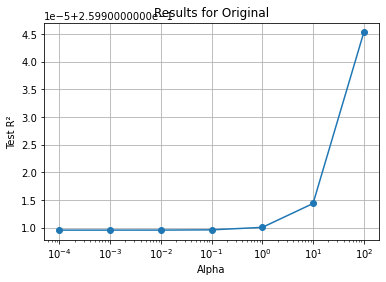

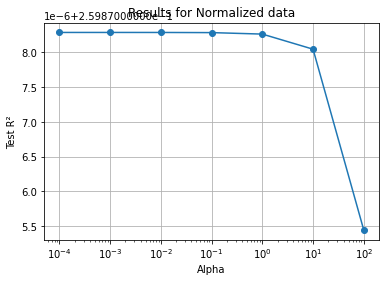

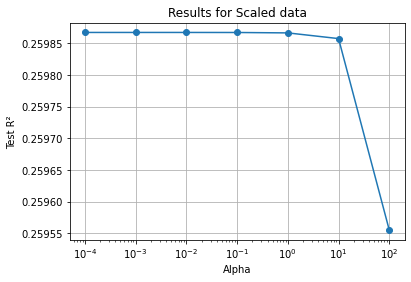

In [40]:
for name in dataframes.keys():
    df_results = direct_fit_results_df[direct_fit_results_df['DataFrame'] == name]
    plt.figure()
    plt.plot(df_results['Alpha'], df_results['Test R²'], marker='o')
    plt.title(f'Results for {name}')
    plt.xlabel('Alpha')
    plt.ylabel('Test R²')
    plt.xscale('log')
    plt.grid(True)
    plt.show()

In [41]:
best_results_index = direct_fit_results_df.groupby('DataFrame')['Test R²'].idxmax()

best_results_df = direct_fit_results_df.loc[best_results_index]
best_results_df.reset_index(drop=True, inplace=True)

best_results_df

,DataFrame,Alpha,Test R²
0,Normalized data,0.0001,0.259878
1,Original,100.0000,0.259945
2,Scaled data,0.0001,0.259867
